## VAEs- Deep Unsupervised Learning Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
import time

### Import libraries
### Choose device
### Define transformations
### Load datasets
### Inspect a batch (for understanding)
### Visualize sample images (for understanding)

In [2]:
# Choose device

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [3]:
def visualize_reconstructed_batch(model, data, reconstructed_data):
    # Get a grid of images from the batch
    images = data.view(-1, 28, 28)
    reconstructed_images = reconstructed_data.view(-1, 28, 28)

    # Ajustar el tamaño de la cuadrícula
    fig, axs = plt.subplots(2, len(images), figsize=(10, 5))

    # Verificar la lógica de indexación
    for i in range(len(reconstructed_images)):
        axs[0, i].imshow(images[i].detach().numpy(), cmap="gray")  # Salia un error relacionado a arrays, añadió detach() y numpy()
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        axs[1, i].imshow(reconstructed_images[i].detach().numpy(), cmap="gray")  # Se añadió detach() y numpy()
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

    fig.suptitle("Sample Reconstructed Images")
    plt.tight_layout()
    plt.show()



In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, num_hidden=8):
        super().__init__()

        # Set the number of hidden units
        self.num_hidden = num_hidden

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(512, 256),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 64, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: num_hidden, output size: 64
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 512),  # input size: 64, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(512, 784),  # input size: 256, output size: 784
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

In [5]:
class VAE(AutoEncoder):
    def __init__(self, num_hidden=8):
        super().__init__(num_hidden=num_hidden)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)

        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)

        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder

        encoded = self.encoder(x)

        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)

        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)

        # Pass the latent variable through the decoder
        decoded = self.decoder(z)

        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)

        # Return the generated samples
        return samples

In [6]:
# Define a loss function that combines MSE and Kullback-Leibler divergence
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    # Compute the MSE loss between the reconstructed output and the input data
    MSE = F.mse_loss(recon_x, x.view(-1, 784), reduction="sum")

    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return MSE + lamb * KLD

In [7]:
def train_vae(model, batch_size=64, learning_rate=1e-3, num_epochs=30):
    # Convert the training data to PyTorch tensors


    #X_train = torch.from_numpy(X_train_np)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    #train_loader = torch.utils.data.DataLoader(
    #    X_train, batch_size=batch_size, shuffle=True
    #)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data,_) in enumerate(trainLoader):
            # Get a batch of training data and move it to the device
            data = data.reshape(data.size(0),-1)
            data = data.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, data, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(trainLoader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

In [8]:
model = VAE(num_hidden=64)
train_vae(model,num_epochs=50)

Epoch 1/50: loss=518.1478
Epoch 2/50: loss=504.1112
Epoch 3/50: loss=499.1153
Epoch 4/50: loss=497.3412
Epoch 5/50: loss=496.3442
Epoch 6/50: loss=495.8256
Epoch 7/50: loss=495.3361
Epoch 8/50: loss=495.0095
Epoch 9/50: loss=494.5022
Epoch 10/50: loss=493.8862
Epoch 11/50: loss=493.4673
Epoch 12/50: loss=493.0803
Epoch 13/50: loss=492.7318
Epoch 14/50: loss=492.4157
Epoch 15/50: loss=492.1532
Epoch 16/50: loss=491.7802
Epoch 17/50: loss=491.5598
Epoch 18/50: loss=491.3677
Epoch 19/50: loss=491.3084
Epoch 20/50: loss=491.1009
Epoch 21/50: loss=491.0242
Epoch 22/50: loss=490.9140
Epoch 23/50: loss=490.8502
Epoch 24/50: loss=490.6531
Epoch 25/50: loss=490.5228
Epoch 26/50: loss=490.3804
Epoch 27/50: loss=490.2109
Epoch 28/50: loss=490.2186
Epoch 29/50: loss=490.1354
Epoch 30/50: loss=490.1102
Epoch 31/50: loss=490.0380
Epoch 32/50: loss=490.0449
Epoch 33/50: loss=489.8208
Epoch 34/50: loss=489.7841
Epoch 35/50: loss=489.8033
Epoch 36/50: loss=489.7825
Epoch 37/50: loss=489.7349
Epoch 38/5

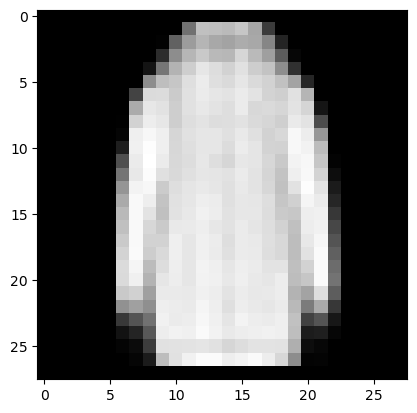

In [9]:
model.eval()

decoded = model.sample(1).view(-1, 28, 28).squeeze().cpu().numpy()

plt.imshow(decoded, cmap="gray")
plt.show()

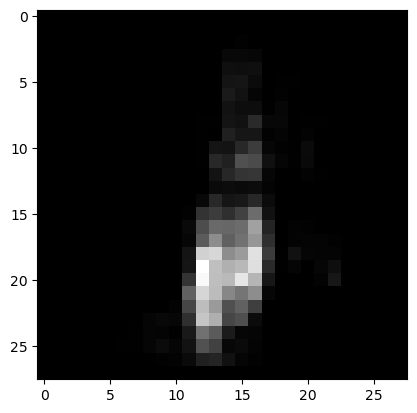

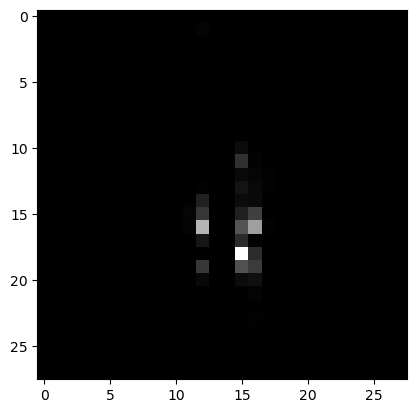

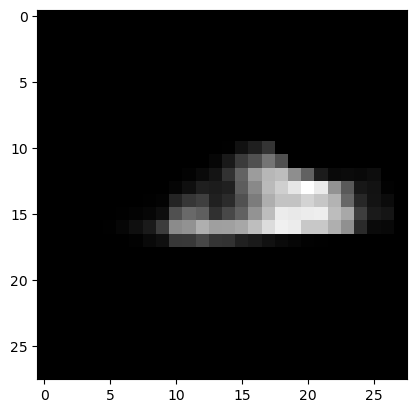

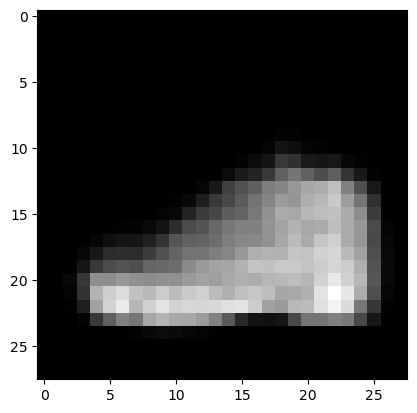

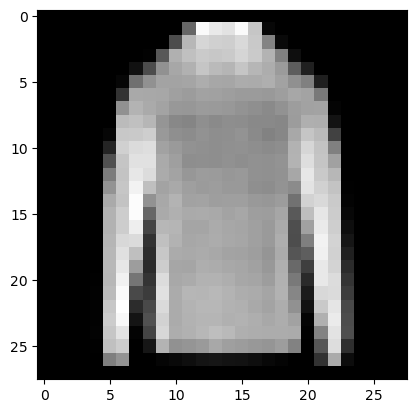

In [10]:
# Set number of images to print
num_images = 5

# Loop to generate and display images
for _ in range(num_images):
  model.eval()
  decoded = model.sample(1).view(-1, 28, 28).squeeze().cpu().numpy()
  plt.imshow(decoded, cmap="gray")
  plt.show()

In [11]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (mu): Linear(in_features=64, out_features=64, bias=True)
  (log_var): Linear(in_features=64, out_features=64, bias=True)
)

Original images


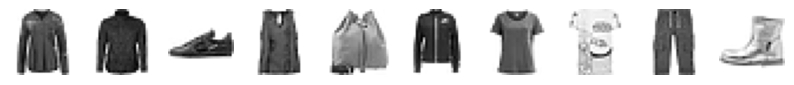

Reconstructed images


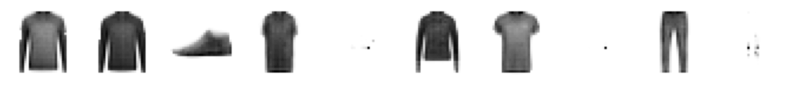

In [16]:
# Get a batch of test images
dataiter = iter(testLoader)
images, labels = next(dataiter)

# Show original images
plt.figure(figsize=(10, 4))
print('Original images')
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()

# Show reconstructed images
with torch.no_grad():
    model.eval()
    images = images.to(device)
    images = images.reshape(images.size(0),-1)
    encoded, outputs, _, _ = model(images)
    outputs = outputs.view(-1,1,28, 28).cpu()
    plt.figure(figsize=(10, 4))
    print('Reconstructed images')
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(outputs[i].numpy().squeeze(), cmap='gray_r')
        plt.axis('off')
    plt.show()

In [17]:
model.encoder(images)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.4365, 0.0000, 2.2786],
        [0.0000, 0.0000, 0.0000,  ..., 1.1168, 0.0000, 3.4685],
        [0.9629, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.5282, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0419, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.2011],
        [0.2070, 0.0000, 0.0000,  ..., 1.8261, 0.0000, 0.0613]],
       device='cuda:0', grad_fn=<ReluBackward0>)